In [4]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from dask.diagnostics import ProgressBar
from itertools import product
from joblib import Parallel, delayed
from collections import defaultdict

import common
import vcm
import fv3viz

In [5]:
@common.memoize_xarray_out
def get_zonal_avg(group, field):
    data = common.open_group(group)
    return vcm.zonal_average_approximate(data.lat, data[field]).load().to_dataset()

In [38]:
from importlib import reload
reload(common)

<module 'common' from '/home/andrep/repos/fv3net/projects/microphysics/docs/manuscript/common.py'>

In [ ]:
levels = vcm.interpolate.PRESSURE_GRID

In [10]:
x = range(0, 70, 2)

In [12]:
x2 = range(0, 70)

In [13]:
yp = np.interp(x2, x, levels)

In [25]:
LEVELS = xr.DataArray(yp[:-1], dims=["pressure"])

In [26]:
def get_zonal_avg_p_interp(group, field):
    delp_key = "pressure_thickness_of_atmospheric_layer"
    delp = get_zonal_avg(group, delp_key)
    data = get_zonal_avg(group, field)
    data[delp_key] = delp[delp_key]
    return common.interp_vertical(data, levels=LEVELS)[field]


Make it faster

In [27]:
base = "zcemu-monthly-init-rh-in-m{init}-30d-v{version}-{run_type}"
fields = [
    "air_temperature",
    "specific_humidity",
    "cloud_water_mixing_ratio"
]
run_types = ["online", "offline"]
inits = [f"{i:02d}" for i in range(1, 13)]

In [28]:

args = list(product(inits, run_types, fields))
jobs = []

for init, run_type, field in args:
    if init == "06":
        version = 2
    else:
        version = 1
    group = base.format(init=init, run_type=run_type, version=version)
    jobs.append(delayed(get_zonal_avg_p_interp)(group, field))

    

In [29]:
results = Parallel(n_jobs=12)(jobs)

In [30]:
def gather(field_key, args, results, drop_time=True):
    out = defaultdict(list)

    for i, ds in enumerate(results):
        month, run_type, field = args[i]
        if field == field_key:
            if drop_time:
                ds = ds.drop_vars(["time"])
            out[run_type].append(ds)
    
    out["offline"] = xr.concat(out["offline"], dim="init")
    out["online"] = xr.concat(out["online"], dim="init")
    
    return out

In [31]:
def get_bias(key, args, results, pct=False, isel_kwargs=None):
    fields = gather(key, args, results)

    if isel_kwargs is None:
        isel_kwargs = {}
    
    online_ds = fields["online"].isel(**isel_kwargs)
    offline_ds = fields["offline"].isel(**isel_kwargs)
    bias = (online_ds - offline_ds).mean(dim="init")
    baseline = offline_ds.mean(dim="init")

    if pct:
        bias /= baseline
    
    return baseline, bias

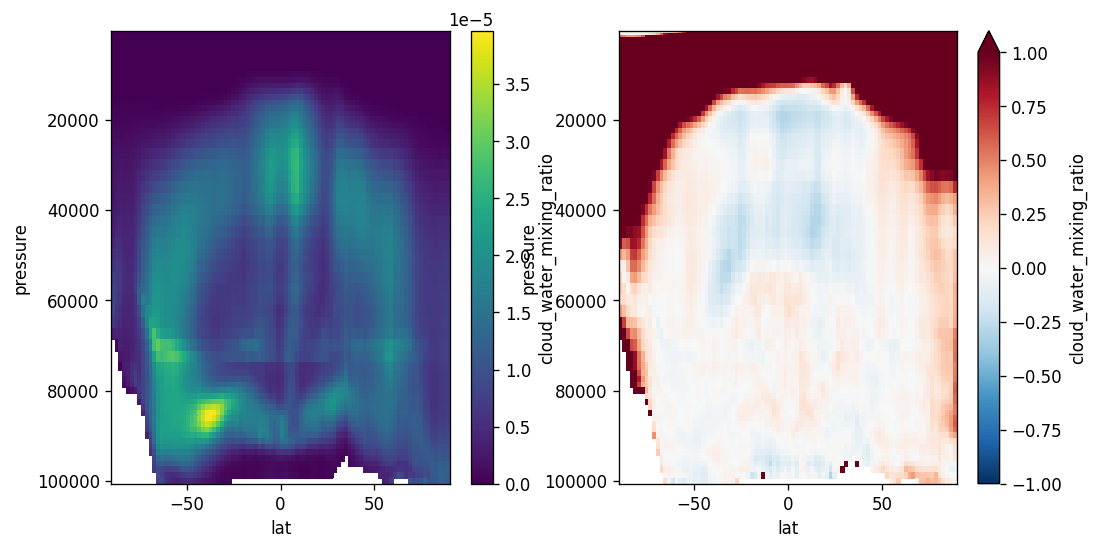

In [32]:
cloud_water, cloud_water_bias = get_bias("cloud_water_mixing_ratio", args, results, pct=True)
fig, ax = plt.subplots(1, 2, dpi=120, figsize=(10, 5))
cloud_water.mean(dim="time").plot(y="pressure", yincrease=False, ax=ax[0])
cloud_water_bias.mean(dim="time").plot(y="pressure", yincrease=False, ax=ax[1], vmin=-1, vmax=1, cmap="RdBu_r")
plt.show()

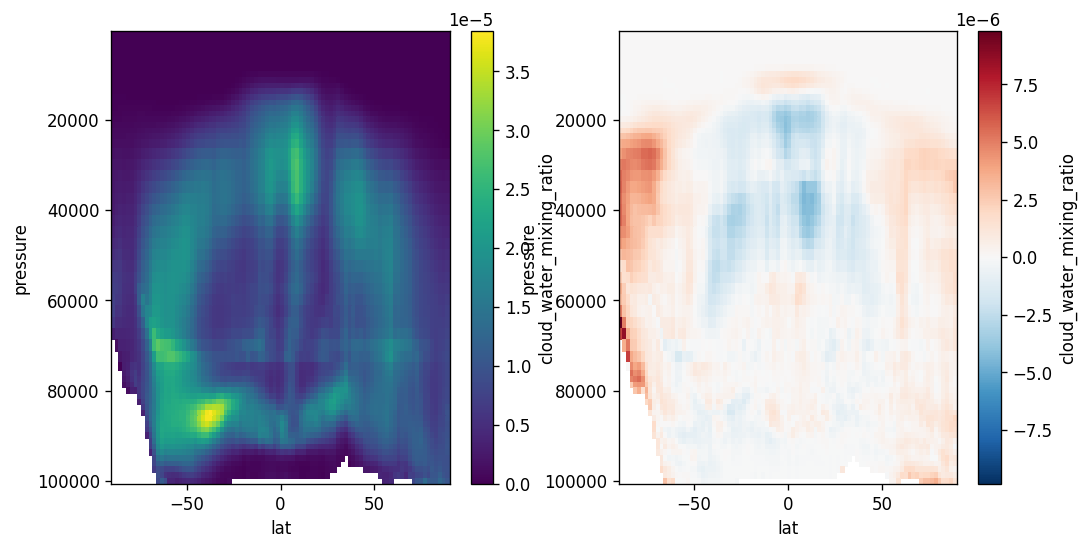

In [33]:
cloud_water, cloud_water_bias = get_bias("cloud_water_mixing_ratio", args, results, pct=False, isel_kwargs=dict(time=slice(80)))
fig, ax = plt.subplots(1, 2, dpi=120, figsize=(10, 5))
cloud_water.mean(dim="time").plot(y="pressure", yincrease=False, ax=ax[0])
cloud_water_bias.mean(dim="time").plot(y="pressure", yincrease=False, ax=ax[1])
plt.show()

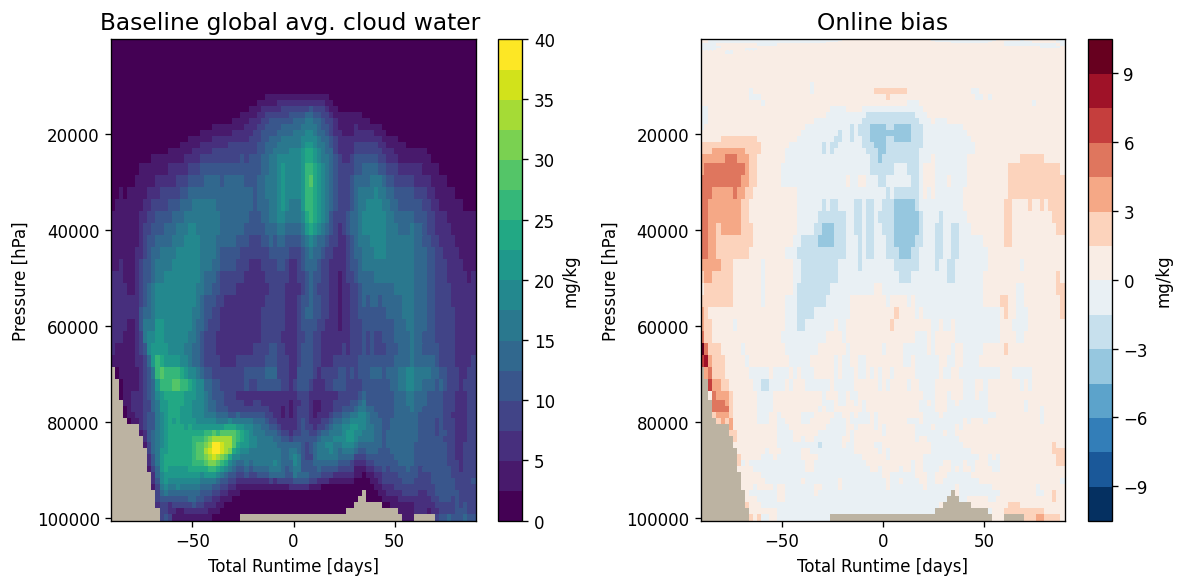

In [40]:
cloud_water, cloud_water_bias = get_bias("cloud_water_mixing_ratio", args, results, pct=False, isel_kwargs=dict(time=slice(80)))
fig, ax = plt.subplots(1, 2, dpi=120, figsize=(10, 5))
(cloud_water * 1e6).mean(dim="time").plot(
    y="pressure", yincrease=False, cmap=common.Viridis_LAND, 
    ax=ax[0], levels=20, cbar_kwargs=dict(label="mg/kg")
)
(cloud_water_bias * 1e6).mean(dim="time").plot(
    y="pressure", yincrease=False, cmap=common.RdBu_LAND,
    ax=ax[1], levels=20, cbar_kwargs=dict(label="mg/kg")
)
ax[0].set_ylabel("Pressure [hPa]")
ax[1].set_ylabel("Pressure [hPa]")
ax[0].set_xlabel("Total Runtime [days]")
ax[1].set_xlabel("Total Runtime [days]")
ax[0].set_title("Baseline global avg. cloud water ", size=14)
ax[1].set_title("Online bias", size=14)
plt.tight_layout()
plt.show()

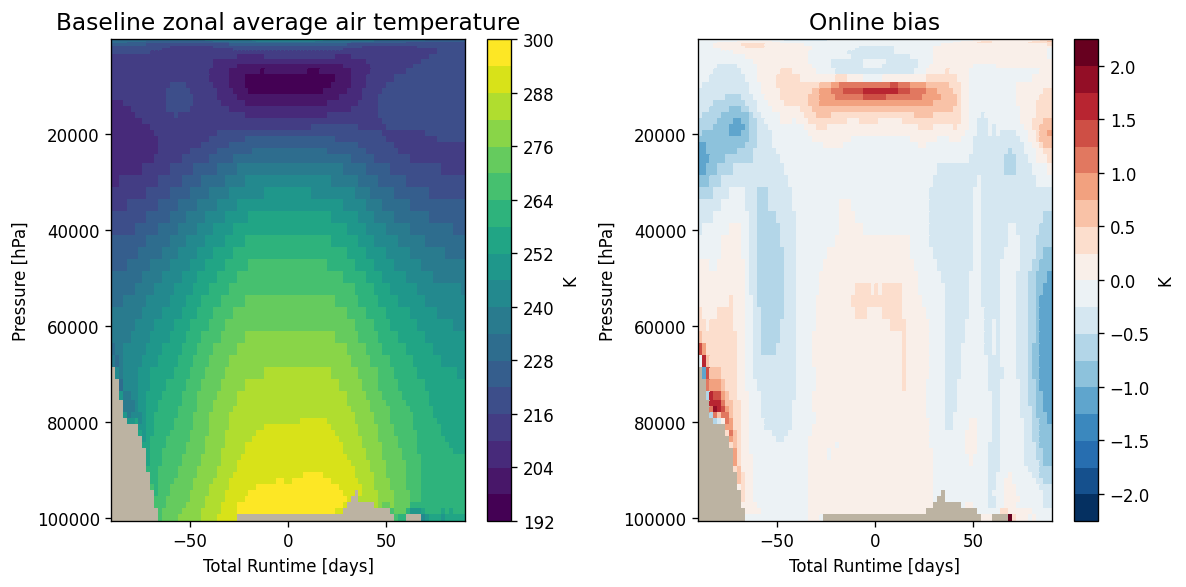

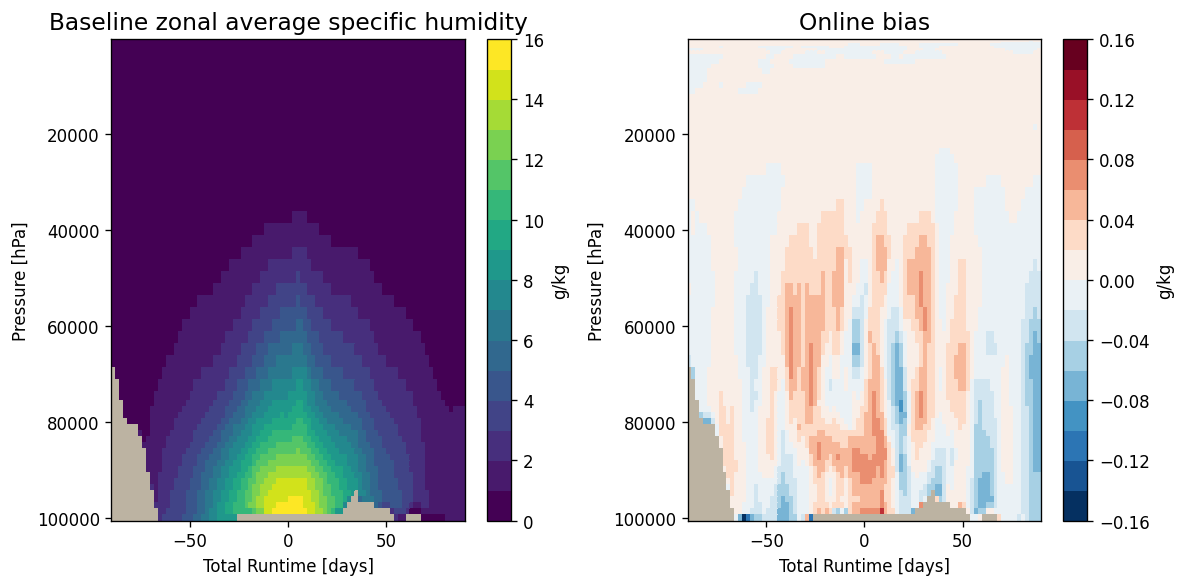

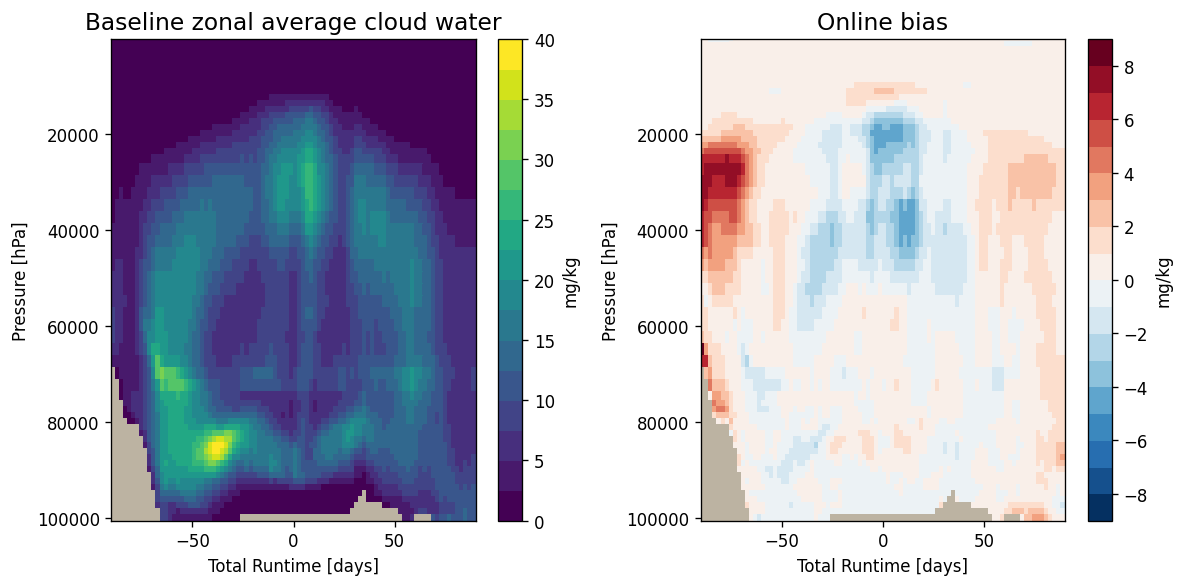

In [41]:
units = {
    "cloud_water_mixing_ratio": "mg/kg",
    "air_temperature": "K",
    "specific_humidity": "g/kg",
}

scale_factors = {
    "cloud_water_mixing_ratio": 1e6,
    "specific_humidity": 1e3,
}

simple_name = {
    "cloud_water_mixing_ratio": "cloud water",
    "air_temperature": "air temperature",
    "specific_humidity": "specific humidity",
}

for f in fields:
    baseline, bias = get_bias(f, args, results, pct=False)
    scale_factor = scale_factors.get(f, 1)
    unit_label = units[f]
    
    fig, ax = plt.subplots(1, 2, dpi=120, figsize=(10, 5))
    (baseline * scale_factor).mean(dim="time").plot(y="pressure", yincrease=False, cmap=common.Viridis_LAND, ax=ax[0], levels=20, cbar_kwargs=dict(label=unit_label))
    (bias * scale_factor).mean(dim="time").plot(y="pressure", yincrease=False, cmap=common.RdBu_LAND, ax=ax[1], levels=20, cbar_kwargs=dict(label=unit_label))
    ax[0].set_ylabel("Pressure [hPa]")
    ax[1].set_ylabel("Pressure [hPa]")
    ax[0].set_xlabel("Total Runtime [days]")
    ax[1].set_xlabel("Total Runtime [days]")
    ax[0].set_title(f"Baseline zonal average {simple_name[f]}", size=14)
    ax[1].set_title("Online bias", size=14)
    plt.tight_layout()
    plt.show()

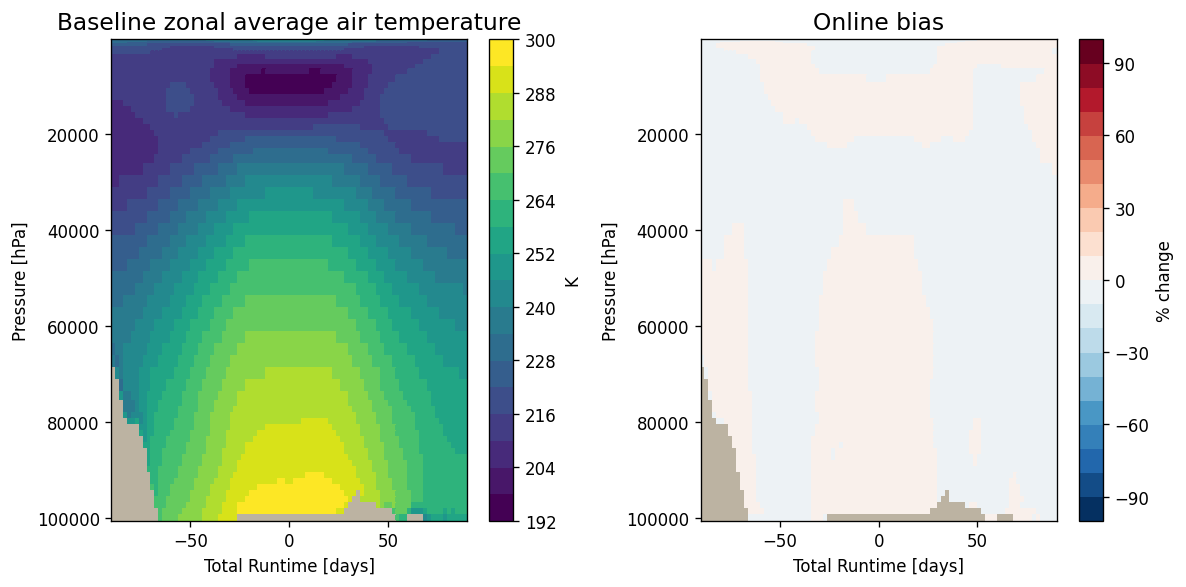

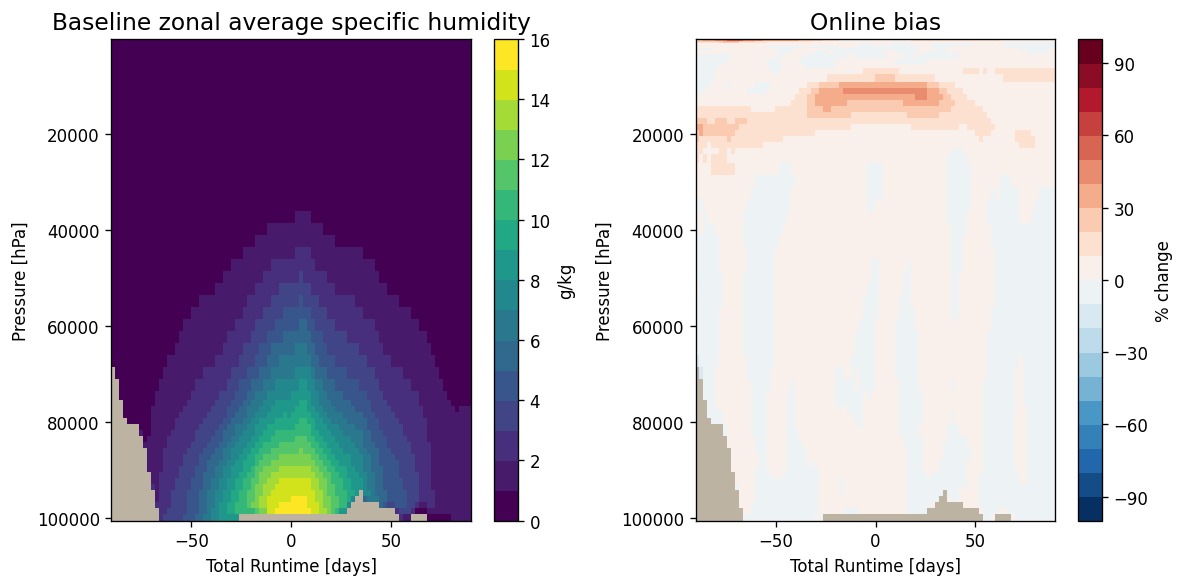

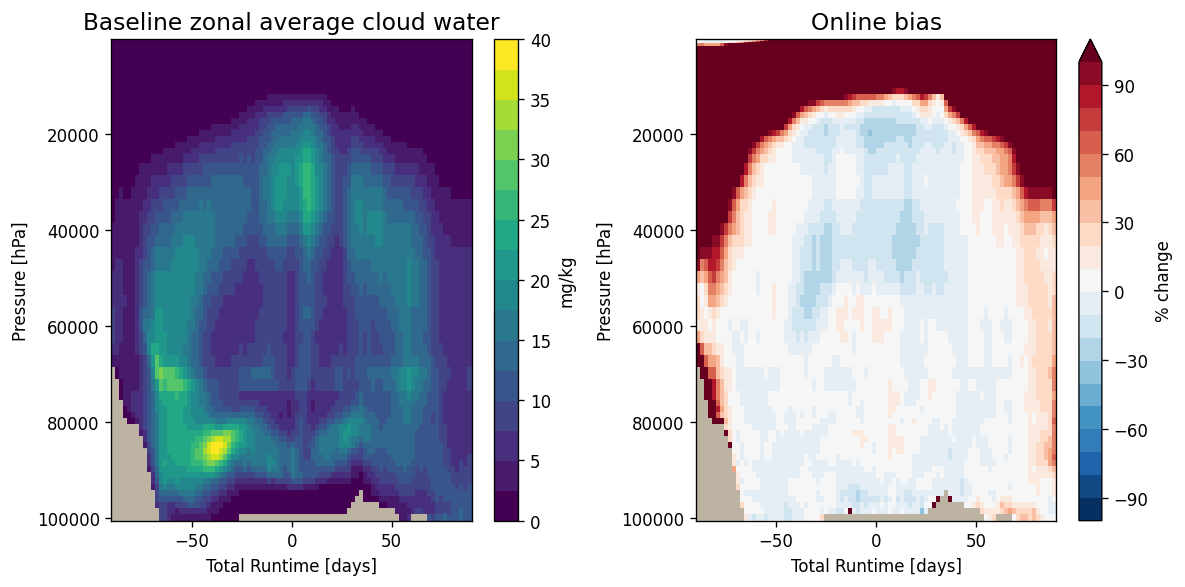

In [45]:
for f in fields:
    baseline, bias = get_bias(f, args, results, pct=True)
    scale_factor = scale_factors.get(f, 1)
    unit_label = units[f]
    
    fig, ax = plt.subplots(1, 2, dpi=120, figsize=(10, 5))
    (baseline * scale_factor).mean(dim="time").plot(y="pressure", yincrease=False, cmap=common.Viridis_LAND, ax=ax[0], levels=20, cbar_kwargs=dict(label=unit_label))
    (bias * 100).mean(dim="time").plot(y="pressure", yincrease=False, ax=ax[1], cmap=common.RdBu_LAND, levels=21, vmin=-100, vmax=100, cbar_kwargs=dict(label="% change"))
    ax[0].set_ylabel("Pressure [hPa]")
    ax[1].set_ylabel("Pressure [hPa]")
    ax[0].set_xlabel("Total Runtime [days]")
    ax[1].set_xlabel("Total Runtime [days]")
    ax[0].set_title(f"Baseline zonal average {simple_name[f]}", size=14)
    ax[1].set_title("Online bias", size=14)
    plt.tight_layout()
    plt.show()